Colab에서 작성한 코드입니다.

기존코드 : https://colab.research.google.com/drive/1HMjual1UYRCWWp7LvlmvUdRq78F43NZn#scrollTo=1KDsSNFEYfgG

# Forecasting model

## Import Necessary Libraries

In [37]:
#data analysis libraries 
import numpy as np
import pandas as pd

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Read in and Explore the Data 

In [38]:
#import train and test CSV files
train_x = pd.read_csv("/content/loan_train.csv")
train_y = pd.read_csv("/content/loan_train_label.csv")
train = pd.merge(train_x,train_y)
test = pd.read_csv("/content/loan_test.csv")

## Data Analysis

unique(중복되지 않는 명목형 데이터의 갯수), top(최빈값), freq(최빈값의 빈도) 등의 3개의 index는 명목형 데이터에 대해서만 사용함

In [39]:
#see a summary of the training dataset
train.describe(include = "all")

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,pymnt_plan,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,recoveries,collection_recovery_fee,policy_code,tot_cur_bal,total_rev_hi_lim,loan_status
count,16000.000000,16000.000000,16000.000000,16000.000000,16000,16000.000000,16000.000000,16000,16000,15011,15191,16000,16000.000000,16000,16000,16000,16000,16000.000000,16000.000000,16000,16000.000000,16000.000000,16000.000000,16000.000000,15991.000000,16000.000000,16000,16000.000000,16000.000000,16000.000000,16000.000000,16000.0,1.400400e+04,1.400400e+04,16000.000000
unique,NaN,NaN,NaN,NaN,2,NaN,NaN,7,35,10412,11,5,NaN,2,14,2830,49,NaN,NaN,527,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,36 months,NaN,NaN,C,C2,Manager,10+ years,MORTGAGE,NaN,n,debt_consolidation,Debt consolidation,CA,NaN,NaN,Aug-2001,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,10895,NaN,NaN,4481,970,179,4947,7481,NaN,15998,9821,6730,2464,NaN,NaN,133,NaN,NaN,NaN,NaN,NaN,NaN,9691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,8000.500000,14691.871875,14671.512500,14611.220088,NaN,14.552899,441.047334,NaN,NaN,NaN,NaN,NaN,71059.510253,NaN,NaN,NaN,NaN,18.217242,0.306750,NaN,0.816875,11.353687,0.177875,15662.826750,56.857532,24.989250,NaN,5888.974696,5886.719976,217.279625,23.840330,1.0,1.301645e+05,2.913961e+04,0.500000
std,4618.946489,8429.444658,8421.274518,8435.308937,NaN,4.536686,246.142880,NaN,NaN,NaN,NaN,NaN,44610.863478,NaN,NaN,NaN,NaN,8.241161,0.868448,NaN,1.058258,5.120252,0.494849,18030.810965,23.742279,11.796682,NaN,8062.958881,8059.825159,840.290799,137.546283,0.0,1.434553e+05,2.855900e+04,0.500016
min,1.000000,1000.000000,1000.000000,0.000000,NaN,5.320000,24.320000,NaN,NaN,NaN,NaN,NaN,4524.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,NaN,0.000000,0.000000,0.000000,0.000000,1.0,0.000000e+00,0.000000e+00,0.000000
25%,4000.750000,8000.000000,8000.000000,8000.000000,NaN,11.530000,264.460000,NaN,NaN,NaN,NaN,NaN,44000.000000,NaN,NaN,NaN,NaN,12.110000,0.000000,NaN,0.000000,8.000000,0.000000,6227.500000,39.800000,16.000000,NaN,0.000000,0.000000,0.000000,0.000000,1.0,2.874075e+04,1.310000e+04,0.000000
50%,8000.500000,12800.000000,12700.000000,12600.000000,NaN,14.310000,386.755000,NaN,NaN,NaN,NaN,NaN,60000.000000,NaN,NaN,NaN,NaN,17.850000,0.000000,NaN,0.000000,11.000000,0.000000,11472.500000,58.500000,23.000000,NaN,0.000000,0.000000,0.000000,0.000000,1.0,7.011400e+04,2.200000e+04,0.500000
75%,12000.250000,20000.000000,20000.000000,20000.000000,NaN,17.570000,576.532500,NaN,NaN,NaN,NaN,NaN,85000.000000,NaN,NaN,NaN,NaN,23.930000,0.000000,NaN,1.000000,14.000000,0.000000,19849.000000,75.200000,32.000000,NaN,10263.235000,10261.097500,0.000000,0.000000,1.0,1.961705e+05,3.660000e+04,1.000000


In [40]:
#결측값 확인
print(pd.isnull(train).sum())

id                            0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                   989
emp_length                  809
home_ownership                0
annual_inc                    0
pymnt_plan                    0
purpose                       0
title                         0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    9
total_acc                     0
initial_list_status           0
out_prncp                     0
out_prncp_inv                 0
recoveries                    0
collection_recovery_fee       0
policy_c

In [41]:
#결측치 ratio 구하기(missingdata_df)
missing_df = train.isnull().sum().reset_index()
missing_df.columns = ['column', 'count']
missing_df['ratio'] = missing_df['count']/train.shape[0]
missingdata_df = missing_df.loc[missing_df['ratio'] != 0]
print(missingdata_df)

              column  count     ratio
9          emp_title    989  0.061812
10        emp_length    809  0.050563
24        revol_util      9  0.000562
32       tot_cur_bal   1996  0.124750
33  total_rev_hi_lim   1996  0.124750


## 데이터 시각화

### grade/subgrade

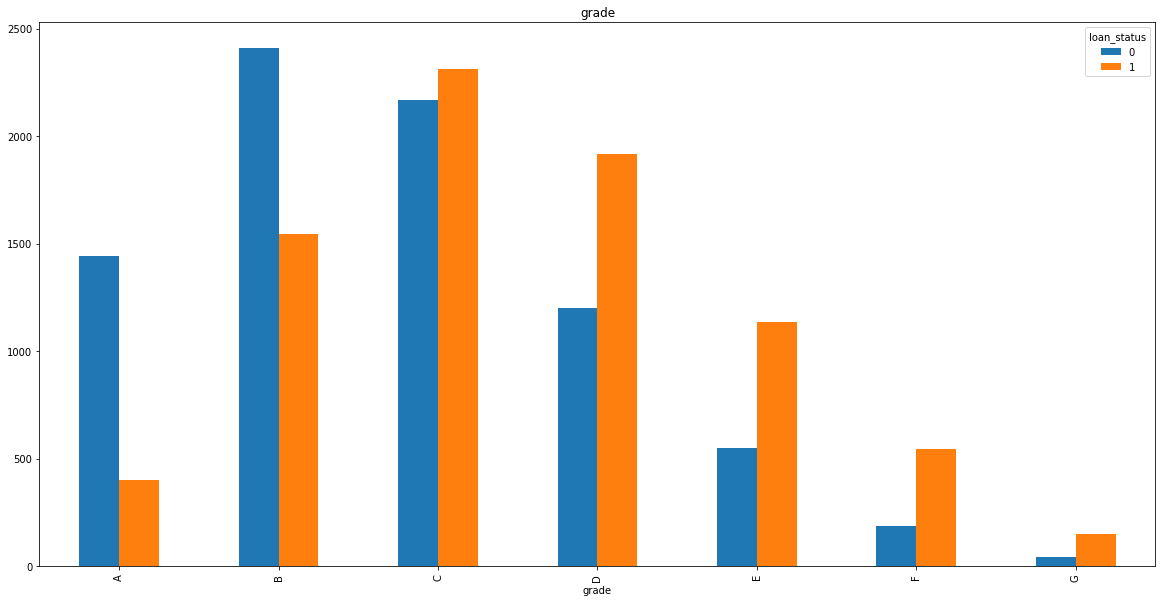

In [42]:
## grade
grade_df = train.groupby(['grade','loan_status'])['loan_status'].count().unstack('loan_status')
grade_df.plot(kind='bar', figsize=(20,10))
plt.title('grade')
plt.show()

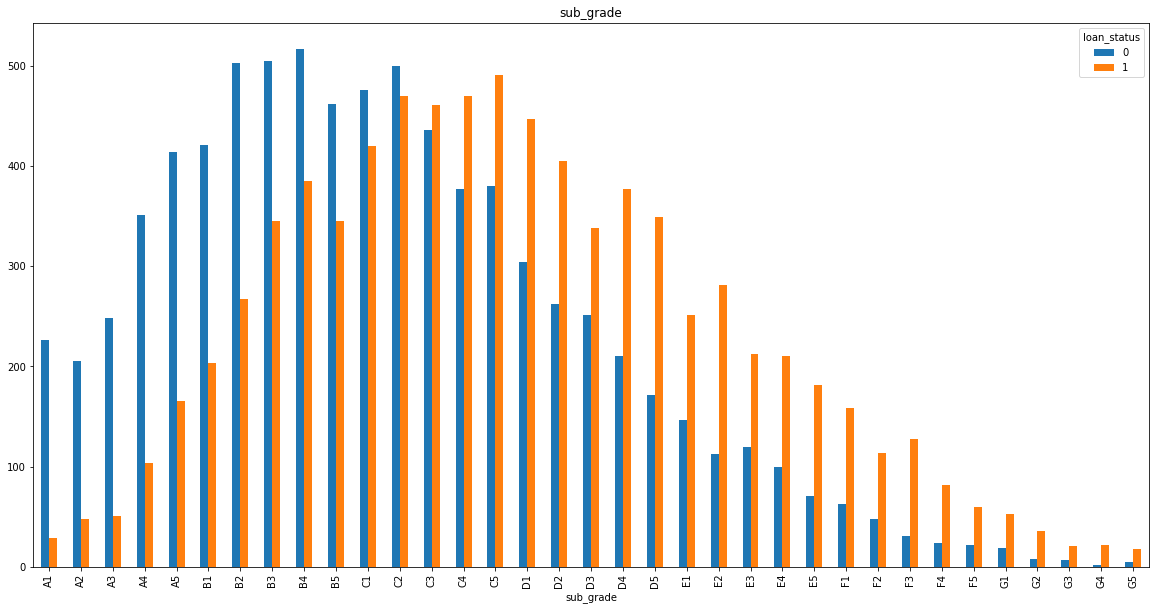

In [43]:
## subgrade
subgrade_df = train.groupby(['sub_grade','loan_status'])['loan_status'].count().unstack('loan_status')
subgrade_df.plot(kind='bar', figsize=(20,10))
plt.title('sub_grade')
plt.show()

### addr_state

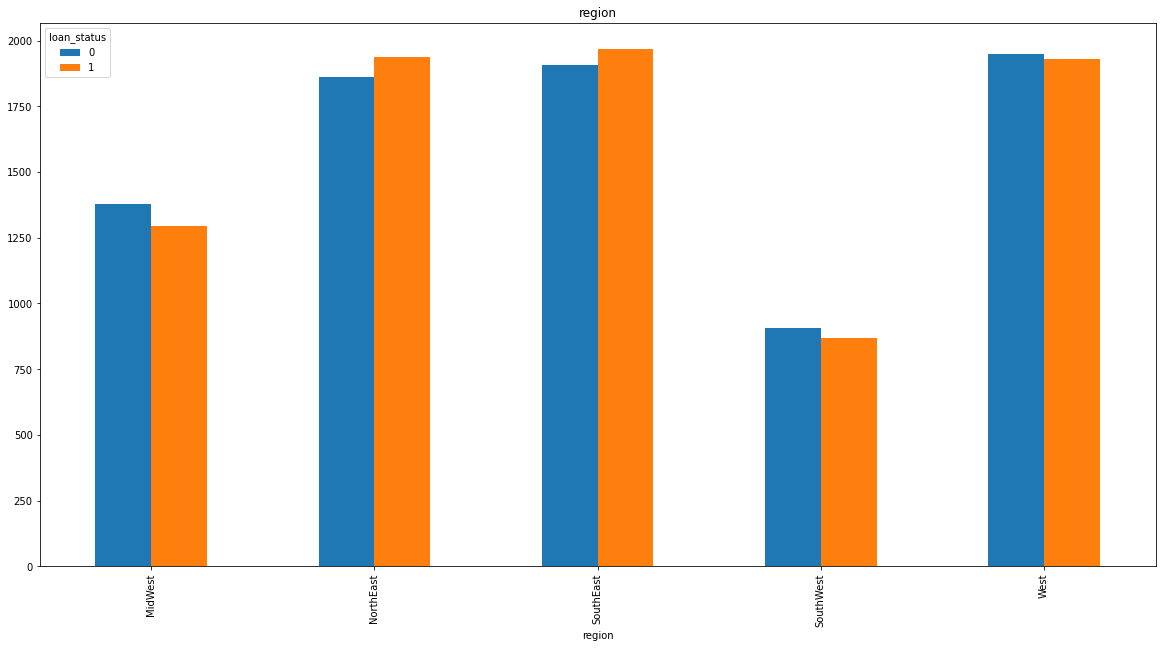

In [44]:
train['addr_state'].unique()

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

train['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'

train['region'] = train['addr_state'].apply(finding_regions)

region_df = train.groupby(['region','loan_status'])['loan_status'].count().unstack('loan_status')
region_df.plot(kind='bar', figsize=(20,10))
plt.title('region')
plt.show()

지역 별 채무불이행 비율 차이가 크지 않기 때문에 무시한다

### home_ownership

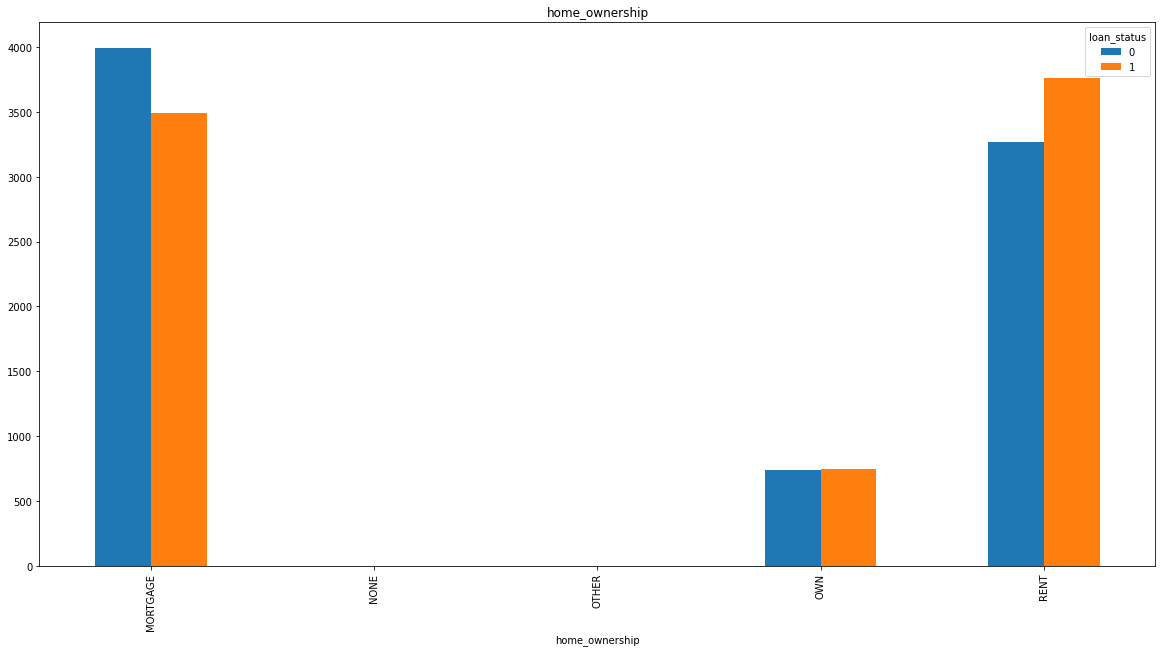

In [45]:
region_df = train.groupby(['home_ownership','loan_status'])['loan_status'].count().unstack('loan_status')
region_df.plot(kind='bar', figsize=(20,10))
plt.title('home_ownership')
plt.show()

유의미한 차이를 보이는 MORTGAGE, RENT만 활용

### purpose

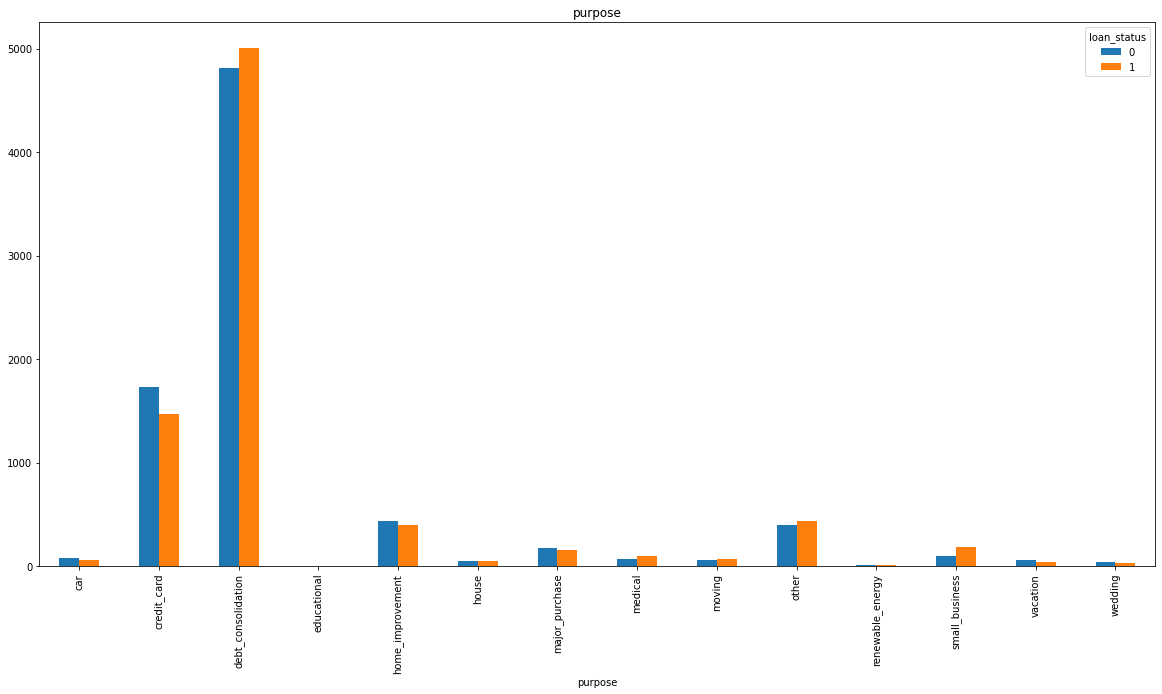

In [46]:
region_df = train.groupby(['purpose','loan_status'])['loan_status'].count().unstack('loan_status')
region_df.plot(kind='bar', figsize=(20,10))
plt.title('purpose')
plt.show()

유의미한 차이를 보이는 credit_card만 활용

## 데이터 축소

### 의미없는 데이터 삭제

##### grade

In [47]:
## 데이터 중복 --> 제외
train = train.drop(['grade'], axis = 1)
test = test.drop(['grade'], axis = 1)

##### emp_title

In [48]:
## 데이터가 매우 다양 --> 제외

train = train.drop(['emp_title'], axis = 1)
test = test.drop(['emp_title'], axis = 1)

##### pymnt_plan

In [49]:
## y가 전체에서 2개 --> 제외

train = train.drop(['pymnt_plan'], axis = 1)
test = test.drop(['pymnt_plan'], axis = 1)

##### title

In [50]:
## 데이터가 매우 다양한 형태 --> 제외

train = train.drop(['title'], axis = 1)
test = test.drop(['title'], axis = 1)

##### addr_state

In [51]:
## 의미없음 --> 제외

train = train.drop(['addr_state'], axis = 1)
test = test.drop(['addr_state'], axis = 1)
train = train.drop(['region'], axis = 1)

##### policy_code

In [52]:
## 의미없음 --> 제외

train = train.drop(['policy_code'], axis = 1)
test = test.drop(['policy_code'], axis = 1)


### 데이터 상관관계

#### 상관관계 확인

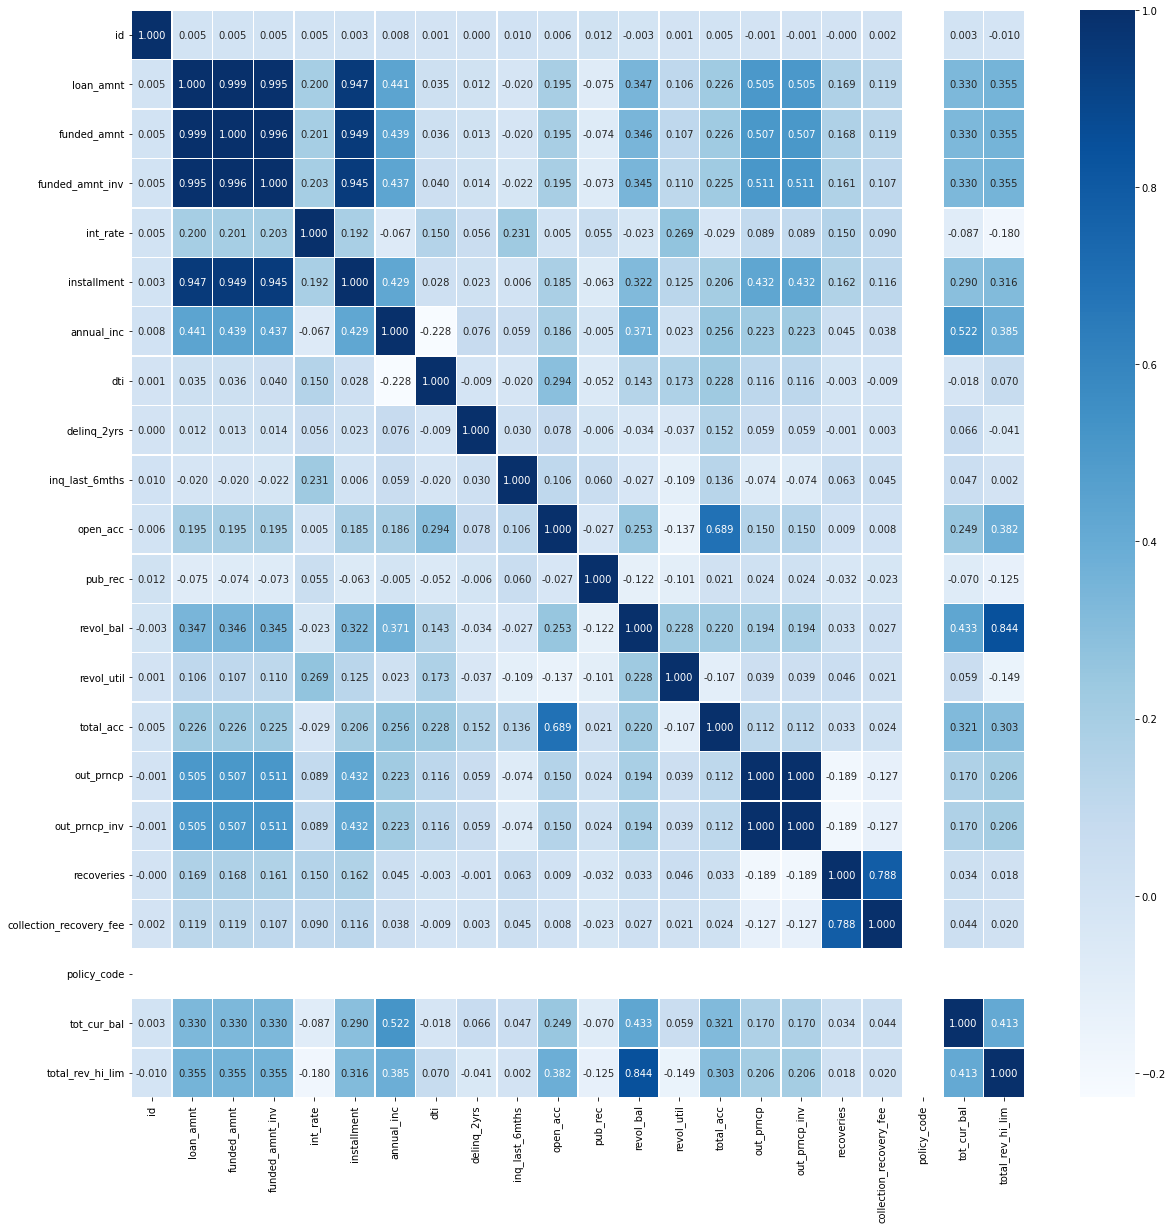

In [53]:
plt.figure(figsize=(20,20))
sns.heatmap(data=train_x.corr(), annot=True, fmt='.3f',linewidths=.4,cmap='Blues')

#### 상관관계 높은 데이터 삭제

##### out_prncp_inv

In [54]:
train = train.drop(['out_prncp_inv'], axis = 1)
test = test.drop(['out_prncp_inv'], axis = 1)

##### collection_recovery_fee

In [55]:
train = train.drop(['collection_recovery_fee'], axis = 1)
test = test.drop(['collection_recovery_fee'], axis = 1)

#### 주성분 분석을 이용한 데이터 축소
loan_amnt, funded_amnt, funded_amnt_inv, installment

In [56]:
## train
from sklearn.preprocessing import StandardScaler
x = train[['loan_amnt','funded_amnt','funded_amnt_inv','installment']].values
x = StandardScaler().fit_transform(x)  #x객체에 x를 표준화한 데이터를 저장
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
principalComponents_train = pca.fit_transform(x)
train['new_loan_amnt'] = principalComponents_train
print(pca.explained_variance_ratio_)

[0.97902809]


In [57]:
## test
from sklearn.preprocessing import StandardScaler
x = test[['loan_amnt','funded_amnt','funded_amnt_inv','installment']].values
x = StandardScaler().fit_transform(x)  #x객체에 x를 표준화한 데이터를 저장
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
principalComponents_test = pca.fit_transform(x)
test['new_loan_amnt'] = principalComponents_test
print(pca.explained_variance_ratio_)

[0.97901001]


In [58]:
train = train.drop(['loan_amnt','funded_amnt','funded_amnt_inv','installment'],axis=1)
test = test.drop(['loan_amnt','funded_amnt','funded_amnt_inv','installment'],axis=1)

## Alphanumeric 데이터 & 문자 데이터

#### term

In [59]:
# month 제거 필요
for i in range(0,len(train["term"])):
  train["term"][i] = int(train["term"][i][:3])
for i in range(0,len(test["term"])):
  test["term"][i] = int(test["term"][i][:3])

#### sub_grade

In [60]:
# 숫자형으로 변환
# train
for i in range(0,len(train["sub_grade"])):

  if train["sub_grade"][i][:1] == "A":
    first = 0
  elif train["sub_grade"][i][:1] == "B":
    first = 5
  elif train["sub_grade"][i][:1] == "C":
    first = 10
  elif train["sub_grade"][i][:1] == "D":
    first = 15
  elif train["sub_grade"][i][:1] == "E":
    first = 20
  elif train["sub_grade"][i][:1] == "F":
    first = 25
  elif train["sub_grade"][i][:1] == "G":
    first = 30
    
  train["sub_grade"][i] = first

In [61]:
# test
for i in range(0,len(test["sub_grade"])):

  if test["sub_grade"][i][:1] == "A":
    first = 0
  elif test["sub_grade"][i][:1] == "B":
    first = 5
  elif test["sub_grade"][i][:1] == "C":
    first = 10
  elif test["sub_grade"][i][:1] == "D":
    first = 15
  elif test["sub_grade"][i][:1] == "E":
    first = 20
  elif test["sub_grade"][i][:1] == "F":
    first = 25
  elif test["sub_grade"][i][:1] == "G":
    first = 30
    
  test["sub_grade"][i] = first

### emp_length

In [62]:
# 숫자형으로 변환
# train
for i in range(0,len(train["emp_length"])):

  if train["emp_length"][i] == "< 1 year":
    length = 0
  elif train["emp_length"][i] == "1 year":
    length = 1
  elif train["emp_length"][i] == "2 years":
    length = 2
  elif train["emp_length"][i] == "3 years":
    length = 3
  elif train["emp_length"][i] == "4 years":
    length = 4
  elif train["emp_length"][i] == "5 years":
    length = 5
  elif train["emp_length"][i] == "6 years":
    length = 6
  elif train["emp_length"][i] == "7 years":
    length = 7
  elif train["emp_length"][i] == "8 years":
    length = 8
  elif train["emp_length"][i] == "9 years":
    length = 9
  elif train["emp_length"][i] == "10+ years":
    length = 10

  train["emp_length"][i] = length

In [63]:
# test
for i in range(0,len(test["emp_length"])):

  if test["emp_length"][i] == "< 1 year":
    length = 0
  elif test["emp_length"][i] == "1 year":
    length = 1
  elif test["emp_length"][i] == "2 years":
    length = 2
  elif test["emp_length"][i] == "3 years":
    length = 3
  elif test["emp_length"][i] == "4 years":
    length = 4
  elif test["emp_length"][i] == "5 years":
    length = 5
  elif test["emp_length"][i] == "6 years":
    length = 6
  elif test["emp_length"][i] == "7 years":
    length = 7
  elif test["emp_length"][i] == "8 years":
    length = 8
  elif test["emp_length"][i] == "9 years":
    length = 9
  elif test["emp_length"][i] == "10+ years":
    length = 10

  test["emp_length"][i] = length

## 범주형 데이터

### home_ownership

In [64]:
# 더미변수화
home_ownership_dummies_train = pd.get_dummies(train["home_ownership"])
home_ownership_dummies_test = pd.get_dummies(test["home_ownership"])
# MORTGAGE와 RENT 유무만 판단
home_ownership_dummies_train = home_ownership_dummies_train.drop(['NONE','OTHER','OWN'], axis = 1)
train = pd.concat([train,home_ownership_dummies_train],axis=1)
home_ownership_dummies_test = home_ownership_dummies_test.drop(['OTHER','OWN'], axis = 1)
test = pd.concat([test,home_ownership_dummies_test],axis=1)

train = train.drop(['home_ownership'], axis = 1)
test = test.drop(['home_ownership'], axis = 1)

### purpose

In [65]:
# 더미변수화
purpose_dummies_train = pd.get_dummies(train["purpose"])
purpose_dummies_test = pd.get_dummies(test["purpose"])
# MORTGAGE와 RENT 유무만 판단
purpose_dummies_train = purpose_dummies_train.drop(['car', 'debt_consolidation', 'educational',
       'home_improvement', 'house', 'major_purchase', 'medical', 'moving',
       'other', 'renewable_energy', 'small_business', 'vacation', 'wedding'], axis = 1)
train = pd.concat([train,purpose_dummies_train],axis=1)
purpose_dummies_test = purpose_dummies_test.drop(['car','debt_consolidation', 'educational',
       'home_improvement', 'house', 'major_purchase', 'medical', 'moving',
       'other', 'renewable_energy', 'small_business', 'vacation', 'wedding'], axis = 1)
test = pd.concat([test,purpose_dummies_test],axis=1)

train = train.drop(['purpose'], axis = 1)
test = test.drop(['purpose'], axis = 1)

### initial_list_status

In [66]:
# 0 or 1로 맵핑
initial_list_status_mapping = {"w": 0, "f": 1}
train['initial_list_status'] = train['initial_list_status'].map(initial_list_status_mapping)
test['initial_list_status'] = test['initial_list_status'].map(initial_list_status_mapping)

train.head()

,id,term,int_rate,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,recoveries,tot_cur_bal,total_rev_hi_lim,loan_status,new_loan_amnt,MORTGAGE,RENT,credit_card
0,1,60,19.99,20,2,46900.0,21.08,0,Jan-2010,2,10,0,11736,39.3,17,0,14401.39,0.0,43804.0,29900.0,0,-0.025863,0,1,0
1,2,36,18.99,20,10,80000.0,22.71,0,Nov-1994,0,10,0,40950,97.7,29,0,11947.70,0.0,50777.0,41900.0,0,1.538320,0,1,0
2,3,60,16.99,15,10,55000.0,15.03,0,Sep-2000,0,10,1,1759,12.0,25,0,9101.23,0.0,149114.0,14700.0,0,-1.217898,1,0,0
3,4,36,15.31,10,2,40000.0,14.52,0,Aug-2005,0,10,0,8996,84.1,14,1,0.00,0.0,75043.0,10700.0,0,-0.522405,0,0,1
4,5,36,9.99,5,10,85000.0,13.24,1,Mar-1993,0,8,0,7974,47.5,29,0,0.00,0.0,259060.0,16800.0,0,1.363500,0,0,0


## 날짜 데이터

### earliest_cr_line

In [67]:
import datetime
today = datetime.datetime.today()

## train
for i in range(0,len(train["earliest_cr_line"])):
  num_train = today - datetime.datetime.strptime(train["earliest_cr_line"][i],'%b-%Y')
  num_train = num_train.days

  train["earliest_cr_line"][i] = num_train

In [68]:
# test
for i in range(0,len(test["earliest_cr_line"])):
  num_test = today - datetime.datetime.strptime(test["earliest_cr_line"][i],'%b-%Y')
  num_test = num_test.days

  test["earliest_cr_line"][i] = num_test

##결측치 제거

### emp_length

In [78]:
 for i in range(0,len(train["emp_length"])):
  #결측값처리 -> 최빈값 10 입력
  if pd.isnull(train["emp_length"][i]) == True:
    length = 10
    train["emp_length"][i] = length

### revol_util

In [79]:
train = train.fillna(train.mean()['revol_util'])
test = test.fillna(test.mean()['revol_util'])

### tot_cur_bal : total_rev_hi_lim

In [80]:
train = train.fillna(train.mean()['tot_cur_bal':'total_rev_hi_lim'])
test = test.fillna(test.mean()['tot_cur_bal':'total_rev_hi_lim'])

## 이상치 제거

In [73]:
def outlier(data, rate=1.5):
    q1 = np.quantile(data, q=0.25)
    q3 = np.quantile(data, q=0.75)
    IQR = q3 - q1
    return (data > q1-IQR * rate) & (data < q3+IQR * rate)

In [74]:
def outlier_recoveries(data, rate=1.5):
    q1 = np.quantile(data, q=0.25)
    q3 = np.quantile(data, q=0.95)
    IQR = q3 - q1
    return (data > q1-IQR * rate) & (data < q3+IQR * rate)

In [75]:
# 연속형 변수 - recoveries는 0값이 3사분위(0.75)이상 차지하고 있어 따로 처리
for i in ['int_rate','annual_inc','dti', 'earliest_cr_line', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'tot_cur_bal','total_rev_hi_lim', 'new_loan_amnt']:

       max_train = np.max(train[i][outlier(train[i])])
       train.loc[train[i]>max_train, i] = max_train

       max_test = np.max(test[i][outlier(test[i])])
       test.loc[test[i]>max_test, i] = max_test

#recoveries 0.95이상에 대해 처리 & rate = 3
i = "recoveries"
max_train = np.max(train[i][outlier_recoveries(train[i])])
train.loc[train[i]>max_train, i] = max_train

max_test = np.max(test[i][outlier_recoveries(test[i])])
test.loc[test[i]>max_test, i] = max_test

## Model

### M1 : Logistic regression - Normal version

Splitting the Training Data

다른 모델에서의 정확도를 테스트하기 위해 training data에서 일부(30%)를 떼어낼 것 -> Train과 val로 구분 7:3

In [83]:
from sklearn.model_selection import train_test_split

predictors = train.drop(['loan_status', 'id'], axis=1)
target = train["loan_status"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.3, random_state = 0)

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
acc_M1 = round(accuracy_score(y_pred, y_val)*100,2)

print(acc_M1)

66.56


###  M2 : Logistic regression - Stepwise Method version

변수선정

In [85]:
!pip install mord dmba

     |████████████████████████████████| 11.8 MB 205 kB/s 
  Created wheel for mord: filename=mord-0.6-py3-none-any.whl size=6006 sha256=ed6ce2045b825c4b08202e70a67c05b039a0878e5db97edd42eb88eba678bf7c
  Stored in directory: /root/.cache/pip/wheels/80/1d/8a/bef1a01b6a3c91494905d161d5426c181819f9730a773141eb
Successfully built mord


In [86]:
from dmba import backward_elimination, forward_selection, stepwise_selection
from sklearn.metrics import accuracy_score
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pylab as plt
import seaborn as sns

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LogisticRegressionCV(penalty="l2", solver='liblinear', cv=5)

    model.fit(predictors[list(variables)], target)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return 0
    target_pred = model.predict(predictors[list(variables)])
    # we negate as score is optimized to be as low as possible
    return -accuracy_score(target, target_pred)

allVariables = predictors.columns
best_fitting, var_fitting = stepwise_selection(allVariables, train_model, 
                                score_model, verbose=True)
print(sorted(var_fitting))

no display found. Using non-interactive Agg backend
Variables: term, int_rate, sub_grade, emp_length, annual_inc, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, out_prncp, recoveries, tot_cur_bal, total_rev_hi_lim, new_loan_amnt, MORTGAGE, RENT, credit_card
Start: score=0.00, constant
Step: score=-0.63, add recoveries
Step: score=-0.68, add sub_grade
Step: score=-0.69, add out_prncp
Step: score=-0.69, add pub_rec
Step: score=-0.69, unchanged None
['out_prncp', 'pub_rec', 'recoveries', 'sub_grade']


Forecasting

In [87]:
predictors = predictors.drop(['term', 'int_rate', 'emp_length', 'annual_inc', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc',
       'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status','tot_cur_bal',
       'total_rev_hi_lim', 'new_loan_amnt', 'MORTGAGE', 'RENT', 'credit_card'], axis=1)
target = train["loan_status"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.3, random_state = 0)

In [88]:
from sklearn.linear_model import LogisticRegression



x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.3, random_state = 0)

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
acc_M2 = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_M2)

69.65


### M3 : Decision Tree(CART)

In [89]:
predictors = train.drop(['loan_status', 'id'], axis=1)
target = train["loan_status"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.3, random_state = 0)

In [90]:
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier(criterion="entropy")
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_val)
acc_M3 = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_M3)

64.02


### M4 : Decision Tree(CART) & avoiding overfitting problem (Using tree growth stopping rules)

In [91]:
predictors = train.drop(['loan_status', 'id'], axis=1)
target = train["loan_status"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.3, random_state = 0)

In [92]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(predictors, target)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
predictors_new = model.transform(predictors)

In [93]:
!pip install dmba

%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
from dmba import plotDecisionTree, classificationSummary, regressionSummary

In [94]:
# Start with an initial guess for parameters
param_grid = {
    'max_depth': [10, 20, 30, 40], 
    'min_samples_split': [20, 40, 60, 80, 100], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(x_train, y_train)

print('Initial score: ',  gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

Initial score:  0.7089285714285715
Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0.001, 'min_samples_split': 20}


In [95]:
y_pred =  bestClassTree.predict(x_val)
acc_M4 = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_M4)

70.92


### Compare result

In [96]:
models = pd.DataFrame({
    'Model': ['M1 : Logistic regression - Normal version', 'M2 : Logistic regression - Stepwise Method version',  'M3 : Decision Tree(CART)','M4 : Decision Tree(CART) & avoiding overfitting problem (Using tree growth stopping rules)'],
    'Score': [acc_M1, acc_M2, acc_M3, acc_M4]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,M4 : Decision Tree(CART) & avoiding overfittin...,70.92
1,M2 : Logistic regression - Stepwise Method ver...,69.65
0,M1 : Logistic regression - Normal version,66.56
2,M3 : Decision Tree(CART),64.02


# Creating Submission File


In [100]:
test_y = pd.read_csv("/content/loan_test_label.csv")

In [101]:
test_x = test.drop(['id'], axis=1)

In [103]:
id = test_y['id']
predictions =  bestClassTree.predict(test_x)

In [104]:
output = pd.DataFrame({ 'id' : id, 'loan_status': predictions })
output.to_csv('loan_test_label.csv', index=False)